## Toy Model 1: 2 spatial modes with different oscillating frequencies

### Created by Yuying Liu, 09/23/2019

$$\Phi(x, t) = u(x)cos(\omega_0 t) + v(x)cos(\omega_1 t + \frac{\pi}{4})$$

In [1]:
# imports
import os
import sys
import torch
import pickle
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import time
import math

module_path = os.path.abspath(os.path.join('../src/'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
    
import torch_cae_multilevel_V4 as net
import ResNet as tnet
import utils

## MrCAE

Below is the progressive training framework. 
One could have flexible control over each training step: low-level models are cheap to obtain, and higher level models are built based on them -- one can always revert back to the previous level and adjust the parameters to re-train the model if it is not satisfying. 

In [2]:
# init model & load data
data_path = '../data/toy2'
model_path = '../model/toy2'
result_path = '../result/toy2/'

full_data_path = os.path.join(data_path, 'data.npy')
data = np.load(full_data_path)

y shape =  torch.Size([5000, 2, 2])


C:\Users\16kat\OneDrive - acornonsite.com\Time_Space_multiscale\src\utils.py:199: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data)


x shape =  (5000, 128, 128)
(5000, 128, 128)
torch.Size([5000, 2, 2])


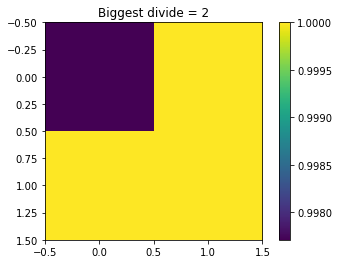

torch.Size([5000, 2, 2])
size_small =  2
size_max =  4
torch.tensor(mse).unsqueeze(0).unsqueeze(0).shape =  torch.Size([1, 1, 4, 4])


In [3]:
unresolved_dict = {}
data_levels_dict = {}

#predict 2x2 and graph
current_size = 2
next_size = current_size * 2
resolved = False
current_data = utils.data_of_size(data,current_size)#
y = utils.data_of_size(data,current_size)
print("y shape = ", y.shape)
x = utils.grow(y)
print("x shape = ", x.shape)
print(data.shape)
next_data = utils.data_of_size(data,next_size)#utils.grow(utils.data_of_size(data,next_size))

print(current_data.shape)
plt.imshow(current_data[0])
plt.title("Biggest divide = "+str(current_size))
plt.colorbar()
plt.show()
print(current_data.shape)
resolved, loss, unresolved = utils.MSE(current_data, next_data, current_size)
unresolved_dict[str(current_size)] = unresolved
data_levels_dict[str(current_size)] = current_data




torch.Size([5000, 2, 2])
torch.Size([5000, 2, 2])
torch.Size([4000, 2, 2])
train data shape =  torch.Size([100, 500, 4])
torch.Size([100, 500, 4])
torch.Size([1, 500, 4])
torch.Size([1, 500, 4])


<ipython-input-4-3e0b042ec0ae>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_data[i] = torch.tensor(train_data_raw[r:r+n_steps].reshape(1,n_steps,x_dim**2))


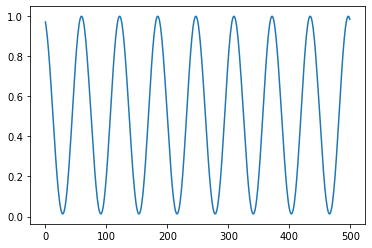

torch.Size([1, 500, 4])
total_dim =  4


In [4]:
#time training on the coursest model



# to_fit =  torch.mean(data_levels_dict['2'], (1,2))
to_fit = data_levels_dict['2']#[:,0,0]
n, x_dim, _ = to_fit.shape

n_steps = 500

print(to_fit.shape)
# print(to_fit.shape)
# print(data_levels_dict['2'].shape)#(1-utils.grow(unresolved_dict['2'].float(),4))*data_levels_dict['4']
# data_this  = to_fit[:,to_fit[0]>0]#data_levels_dict['2']
data_this = to_fit
print(data_this.shape)
# n = len(data_this)

train_data_raw = data_this[:(n-2*n_steps)]
print(train_data_raw.shape)
random_starts = np.random.randint(0,4000 - n_steps, 100)
train_data = torch.zeros((100,n_steps,x_dim**2))
for (i,r) in enumerate(random_starts):
    train_data[i] = torch.tensor(train_data_raw[r:r+n_steps].reshape(1,n_steps,x_dim**2))
    
print("train data shape = ", train_data.shape)

val_data = data_this[(n - 2*n_steps):(n-n_steps)].reshape((1, n_steps, x_dim**2))
test_data = data_this[(n-n_steps):].reshape((1, n_steps, x_dim**2))


# train_encoded = model_space.encode(train_data, model_space.cur_level).reshape((1, len(train_data), len(encoded[0,0])**2))
# val_encoded = model_space.encode(val_data, model_space.cur_level).reshape((1, len(val_data), len(encoded[0,0])**2))
# test_encoded = model_space.encode(test_data, model_space.cur_level).reshape((1, len(test_data), len(encoded[0,0])**2))

print(train_data.shape)
print(val_data.shape)
print(test_data.shape)

# plt.imshow(train_data[0].reshape(2,2))
plt.plot(train_data[0,:,0])
# plt.colorbar()
plt.show()

#getting time inputs
# t = np.linspace(0, 8*np.pi, 500)
k = 0                         # model index: should be in {0, 2, ..., 10}
dt = 1#t[1] - t[0]              # time unit: 0.0005 for Lorenz and 0.01 for others
system = 'toy2'
noise = 0.0                   # noise percentage: 0.00, 0.01 or 0.02

lr = 1e-3                     # learning rate
max_epochs = 10000            # the maximum training epoch 
batch_size = 320              # training batch size
min_k = 0
max_k = 7

print(val_data.shape)
_,n_steps, total_dim= val_data.shape
n_steps = n_steps - 1
# total_dim = n_per_dim **2
print("total_dim = ", total_dim)
arch = [total_dim, 128, 128, 128, total_dim] 

# global const
n_forward = 6
step_size = 2**k

criterion = torch.nn.MSELoss(reduction='none')
# print(dt)
# dataset = tnet.DataSet(train_encoded, val_encoded, test_encoded, dt, step_size, n_forward)

unresolved_dict = {}

In [5]:
def train_one_timestep(k, train_data, val_data, test_data, current_size, dt = 1, n_forward = 5, noise=0, make_new = False, dont_train = False):
    step_size = 2**k
    dataset = tnet.DataSet(train_data, val_data, test_data, dt, step_size, n_forward)#tnet.DataSet(train_data, val_data, test_data, dt, step_size, n_forward)
    model_name = 'model_L{}_D{}_noise{}.pt'.format(current_size,step_size, noise)
    model_path_this = os.path.join(model_path, model_name)

    # create/load model object
    print("make_new = ", make_new)
    try:
        if make_new:
            ghj
    #         device = 'cuda' if torch.cuda.is_available() else 'cpu'
        model_time = torch.load(model_path_this)#, map_location=device)
        print("model loaded")
    #     model_time.device = device
        print("don't train = ", dont_train)
        if dont_train:
            return model_time
    except:
        print('create model {} ...'.format(model_name))
        print('dt = ', dt)
        model_time = tnet.ResNet(arch=arch, dt=dt, step_size=step_size)

    # training
    model_time.train_net(dataset, max_epoch=max_epochs, batch_size=batch_size, lr=lr,
                    model_path=os.path.join(model_path, model_name),threshold= 1e-4)
    
    return model_time

def find_best_timestep(train_data, val_data, test_data, current_size, start_k = 0, largest_k = 7, dt = 1, n_forward = 5, noise=0, make_new = False, dont_train = False):
    models = list()
    step_sizes = list()
    mse_lowest = 1e10 #big number
    mse_list = list()
    mse_less = 0
    idx_lowest = -1
    
    for k in range(7):
        step_size = 2**k
        step_sizes.append(step_size)
        model_time = train_one_timestep(k, train_data, val_data, test_data, current_size, make_new = make_new, dont_train = dont_train)
        models.append(model_time)
    
        #find error
        y_preds = model_time.uni_scale_forecast(torch.tensor(val_data[:, 0, :]).float(), n_steps=n_steps)
        mse_all = criterion(torch.tensor(val_data[:, 1:, :]).float(), y_preds).mean(-1)
#         print(mse_all.shape)
        # step_every = step_sizes[k]
        mean = mse_all.mean(0).detach().numpy()
#         print(mean.shape)
        mse_less = mean.mean()
        mse_list.append(mse_less)

        print("mse_lowest = ", mse_lowest)
        print("mse_less= ", mse_less)
        
        if (mse_less< mse_lowest) or (math.isnan(mse_lowest)) or (math.isnan(mse_less)):
            mse_lowest = mse_less
            idx_lowest = k
#         else:
#             print("Done. Best model at k = ", k-1)
#             return models[:-1], step_sizes[:-1], mse_list[:-1]

    return models, step_sizes, mse_list, idx_lowest

In [6]:
#do time training for smallest time step

models, step_sizes, mse_list, idx_lowest = find_best_timestep(train_data, val_data, test_data, 
                                                  current_size, make_new = False, dont_train = True)

print(len(models))
print(step_sizes)
print(mse_list)


make_new =  False
model loaded
don't train =  True


C:\Users\16kat\anaconda3\lib\site-packages\torch\cuda\__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0
C:\Users\16kat\OneDrive - acornonsite.com\Time_Space_multiscale\src\utils_time.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.train_x = torch.tensor(train_data[:, x_idx, :]).float().to(self.device)
C:\Users\16kat\OneDrive - acornonsite.com\Time_Space_multiscale\src\utils_time.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTenso

mse_lowest =  10000000000.0
mse_less=  nan
make_new =  False
model loaded
don't train =  True
mse_lowest =  nan
mse_less=  0.23722877
make_new =  False
model loaded
don't train =  True
mse_lowest =  0.23722877
mse_less=  0.018851679
make_new =  False
model loaded
don't train =  True
mse_lowest =  0.018851679
mse_less=  73.15107
make_new =  False
model loaded
don't train =  True
mse_lowest =  0.018851679
mse_less=  0.18685253
make_new =  False
model loaded
don't train =  True
mse_lowest =  0.018851679
mse_less=  0.061529204
make_new =  False
model loaded
don't train =  True
mse_lowest =  0.018851679
mse_less=  0.2709497
7
[1, 2, 4, 8, 16, 32, 64]
[nan, 0.23722877, 0.018851679, 73.15107, 0.18685253, 0.061529204, 0.2709497]


2
torch.Size([1, 500, 4])
torch.Size([1, 499, 4])
8


<ipython-input-7-475e41003271>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_preds = model.uni_scale_forecast(torch.tensor(val_data[:,0,:]).float(), n_steps=n_steps)


(-0.1, 1.1)

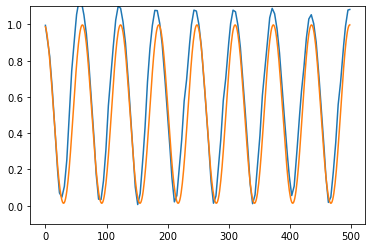

In [7]:
print(idx_lowest)
model = models[idx_lowest]
print(val_data.shape)
y_preds = model.uni_scale_forecast(torch.tensor(val_data[:,0,:]).float(), n_steps=n_steps)
print(y_preds.shape)
print(len(range(0,499,64)))
plt.plot(y_preds[0,:,0])
plt.plot(val_data[0,1:,0])
plt.ylim([-.1, 1.1])
# plt.show()
# plt.plot(val_data_2x2[1:, 0,0])
# plt.plot(range(0,499, 4),val_data[0,::4,0], '.')

torch.Size([1, 500, 4])
y_preds.shape = torch.Size([1, 499, 4])


<ipython-input-8-432637c2c962>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_preds = model.uni_scale_forecast(torch.tensor(val_data[:, 0, :]).float(), n_steps=n_steps)
C:\Users\16kat\OneDrive - acornonsite.com\Time_Space_multiscale\src\ResNet.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds.insert(0, torch.tensor(x_init).float().to(self.device))
C:\Users\16kat\anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:605: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\16kat\anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:608: RuntimeWarning: invalid value encountered in multiply
  y_new =

criterion(torch.tensor(val_data[:, 1:, :]).float(), y_preds) shape = torch.Size([1, 499])
1
torch.Size([1, 500, 4])
y_preds.shape = torch.Size([1, 499, 4])
criterion(torch.tensor(val_data[:, 1:, :]).float(), y_preds) shape = torch.Size([1, 499])
2
torch.Size([1, 500, 4])
y_preds.shape = torch.Size([1, 499, 4])
criterion(torch.tensor(val_data[:, 1:, :]).float(), y_preds) shape = torch.Size([1, 499])
3
torch.Size([1, 500, 4])
y_preds.shape =

<ipython-input-8-432637c2c962>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds_mse.append(criterion(torch.tensor(val_data[:, 1:, :]).float(), y_preds).mean(-1))


 torch.Size([1, 499, 4])
criterion(torch.tensor(val_data[:, 1:, :]).float(), y_preds) shape = torch.Size([1, 499])
4
torch.Size([1, 500, 4])
y_preds.shape = torch.Size([1, 499, 4])
criterion(torch.tensor(val_data[:, 1:, :]).float(), y_preds) shape = torch.Size([1, 499])
5
torch.Size([1, 500, 4])
y_preds.shape = torch.Size([1, 499, 4])
criterion(torch.tensor(val_data[:, 1:, :]).float(), y_preds) shape = torch.Size([1, 499])
6
torch.Size([1, 500, 4])
y_preds.shape = torch.Size([1, 499, 4])
criterion(torch.tensor(val_data[:, 1:, :]).float(), y_preds) shape = torch.Size([1, 499])
7

len(models) =  7
len preds_mse =  7
step_sizes =  [1, 2, 4, 8, 16, 32, 64]
err.shape =  torch.Size([1, 499])
(499,)
err.shape =  torch.Size([1, 499])
(499,)
err.shape =  torch.Size([1, 499])
(499,)
err.shape =  torch.Size([1, 499])
(499,)
err.shape =  torch.Size([1, 499])
(499,)
err.shape =  torch.Size([1, 499])
(499,)
err.shape =  torch.Size([1, 499])
(499,)


(1e-05, 10)

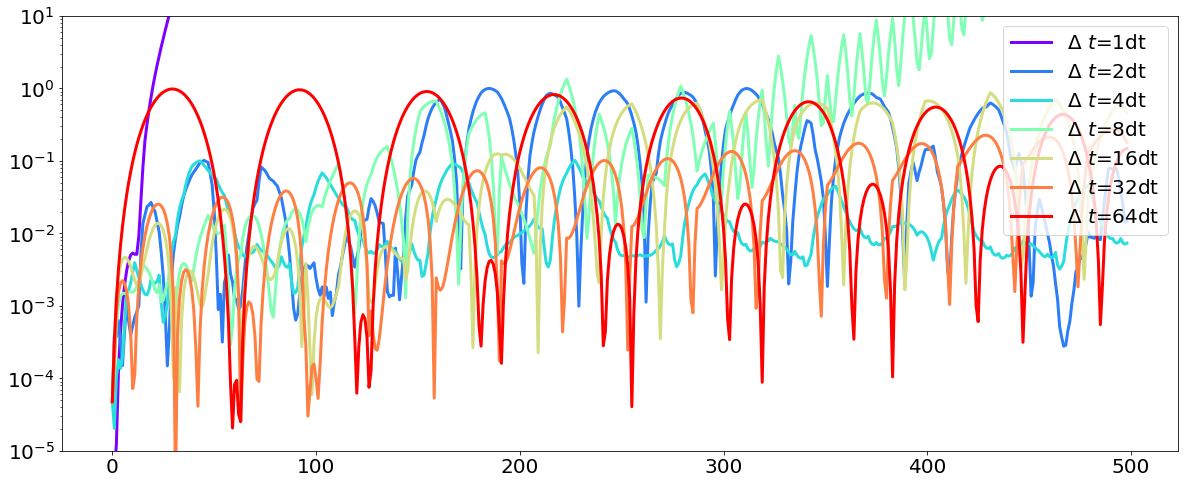

In [8]:
# # uniscale time-stepping with NN
preds_mse = list()
times = list()

for model in tqdm(models):
    start = time.time()
    print(val_data.shape)
    y_preds = model.uni_scale_forecast(torch.tensor(val_data[:, 0, :]).float(), n_steps=n_steps)
    print("y_preds.shape =", y_preds.shape)
    end = time.time()
    times.append(end - start)
    print('criterion(torch.tensor(val_data[:, 1:, :]).float(), y_preds) shape =', criterion(torch.tensor(val_data[:, 1:, :]).float(), y_preds).mean(-1).shape )
    preds_mse.append(criterion(torch.tensor(val_data[:, 1:, :]).float(), y_preds).mean(-1))
    print(len(preds_mse))
    
# visualize forecasting error at each time step    
fig = plt.figure(figsize=(20, 8))
colors=iter(plt.cm.rainbow(np.linspace(0, 1, len(models))))
print(colors)
print("len(models) = ", len(models))
print("len preds_mse = ", len(preds_mse))
print("step_sizes = ", step_sizes)
for k in range(len(models)):
    err = preds_mse[k]
    print('err.shape = ', err.shape)
    mean = err[0].detach().numpy()
    rgb = next(colors)
    print(mean.shape)
#     print(len(t))
#     print(t)
    plt.semilogy(mean, linestyle='-', color=rgb, linewidth=3.0, label='$\Delta\ t$={}dt'.format(step_sizes[k]))
plt.legend(fontsize=20, loc='upper right')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.ylim([1e-5, 10])
# plt.xlim([0, len(t)])
    

In [9]:
val_data_4x4 = utils.data_of_size(data,4)
plt.imshow(val_data_4x4[1])
plt.colorbar()
plt.show()

print(y_preds.shape)
plt.imshow(y_preds[0,0].reshape(2,2))
plt.colorbar()
plt.show()
print(val_data_4x4.shape)

F1- = utils.MSE(utils.grow(y_preds.reshape(499,2,2), 4), val_data[0,1:,:].reshape(499, 2,2), 4,  keep_small = False)
# mse = criterion(grow(y_preds.reshape(499,2,2), 4), val_data[0,1:,:].reshape(499, 2,2))
print(loss)
print(unresolved)
plt.imshow(loss)
plt.colorbar()

SyntaxError: invalid syntax (<ipython-input-9-a758360899a3>, line 12)

In [ ]:
model = models[idx_lowest]
y_preds = model.uni_scale_forecast(torch.tensor(val_data[:, 0, :]).float(), n_steps=n_steps)

to_fit =  data_levels_dict['2']
data_this = to_fit
print(data_this.shape)
n = len(data_this)

val_data_2x2 = data_this[int(n*0.8):int(0.9*n)].reshape((500, 2,2))
# test_data = data_this[int(0.9*n):].reshape((1, 500, 1))

print("y_preds = ", y_preds.shape)
print("val_data[:, 1:, :] = ", val_data_2x2[:, 1:, :].shape)

# resolved, loss, unresolved = utils.MSE(y_preds.reshape(499, ), val_data_2x2[1:, :, :].reshape(499, 2,2), current_size*2, keep_small = False)
unresolved_dict[str(current_size)] = unresolved
print("loss shape = ", loss.shape)
# data_levels_dict[str(current_size)] = current_data

In [ ]:
print(y_preds.shape)
mse = criterion(y_preds.reshape(499,2,2), val_data[0,1:,:].reshape(499, 2,2))
print(mse)

In [ ]:
print(idx_lowest)
model = models[idx_lowest]
y_preds = model.uni_scale_forecast(torch.tensor(val_data[:, 0, :]).float(), n_steps=n_steps)
plt.plot(y_preds[0,:,0])
plt.plot(val_data_2x2[1:, 0,0])

In [ ]:
print(loss)

In [ ]:
#train next timestep
k = 1
print("k = ", k)
model_time = train_one_timestep(k, train_data, val_data, test_data, current_size)#, make_new
    
#find error and save if less
y_preds = model_time.uni_scale_forecast(torch.tensor(val_data[:, 0, :]).float(), n_steps=n_steps)
mse_all = criterion(torch.tensor(val_data[:, 1:, :]).float(), y_preds).mean(-1)
print(mse_all.shape)
step_every  = 2**(k-1)
mean = mse_all.mean(0).detach().numpy()
print(mean.shape)
mse_less = mean[::step_every].mean()

if (mse_less< mse_lowest) or (math.isnan(mse_lowest)):
    mse_lowest = mse_less
else:
    print("Done. Best model at k = ", k-1)

print(mse_less)

In [ ]:
#train next timestep
k = 2
print("k = ", k)
model_time = train_one_timestep(k, train_data, val_data, test_data, current_size)#, make_new=True)
    
#find error and save if less
y_preds = model_time.uni_scale_forecast(torch.tensor(val_data[:, 0, :]).float(), n_steps=n_steps)
mse_all = criterion(torch.tensor(val_data[:, 1:, :]).float(), y_preds).mean(-1)
print(mse_all.shape)
step_every  = 2**(k-1)
mean = mse_all.mean(0).detach().numpy()
print(mean.shape)
mse_less = mean[::step_every].mean()

if (mse_less< mse_lowest) or (math.isnan(mse_lowest)):
    mse_lowest = mse_less
else:
    print("Done. Best model at k = ", k-1)

print("mse_lowest = ", mse_lowest)
print("mse_less= ", mse_less)

In [ ]:
#find error at this step size
y_preds = model.uni_scale_forecast(torch.tensor(val_data[:, 0, :]).float(), n_steps=n_steps)
mse_all = criterion(torch.tensor(val_data[:, 1:, :]).float(), y_preds).mean(-1)
step_every = step_sizes[k-1]
mse_less = mean[::step_every].mean()

# # uniscale time-stepping with NN
preds_mse = list()
times = list()

for model in tqdm(time_models):
    start = time.time()
#     print(val_encoded.shape)
    y_preds = model.uni_scale_forecast(torch.tensor(val_data[:, 0, :]).float(), n_steps=n_steps)
#     print("y_preds.shape =", y_preds.shape)
    end = time.time()
    times.append(end - start)
    print('criterion(torch.tensor(val_encoded[:, 1:, :]).float(), y_preds) shape =', criterion(torch.tensor(val_data[:, 1:, :]).float(), y_preds).mean(-1).shape )
    preds_mse.append(criterion(torch.tensor(val_data[:, 1:, :]).float(), y_preds).mean(-1))
#     print("len(preds_mse) = ", len(preds_mse))
    
print(len(preds_mse))
print(len(preds_mse[0]))
# visualize forecasting error at each time step    
fig = plt.figure(figsize=(20, 8))
colors=iter(plt.cm.rainbow(np.linspace(0, 1, max_k-min_k)))
# print(len(colors))
for k in range(max_k-min_k):
    print("k = ", k)
    err = preds_mse[k]
#     print('err.shape = ', err.shape)
    mean = err[0].detach().numpy()
    rgb = next(colors)
#     print(mean.shape)
#     print(len(t))
#     print(t)
    plt.semilogy(mean, linestyle='-', color=rgb, linewidth=3.0, label='$\Delta\ t$={}dt'.format(step_sizes[k]))
plt.legend(fontsize=20, loc='upper right')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.ylim([1e-5, 10])
plt.show()
# plt.xlim([0, len(t)])

fig = plt.figure(figsize=(20, 8))
colors=iter(plt.cm.rainbow(np.linspace(0, 1, max_k-min_k)))
print(colors)
for k in range(max_k-min_k):
    err = preds_mse[k]
    mean = err.mean(0).detach().numpy()
#     print(np.mean(mean[::step_every]))
    rgb = next(colors)
    step_every = step_sizes[k-1]
    t = range(len(mean))
    if step_every == 1:
        plt.semilogy(t, mean, linestyle='-', color=rgb, linewidth=3.0, label='$\Delta\ t$={}dt'.format(step_sizes[k]))
    else:
        plt.semilogy(t[::step_every], mean[::step_every], linestyle='-', color=rgb, linewidth=3.0, label='$\Delta\ t$={}dt'.format(step_sizes[k]))
    print("K = ", k,": step_size = ", step_sizes[k], ": mean = ", mean[::step_every].mean())
plt.legend(fontsize=20, loc='upper right')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.ylim([1e-5, 10])
    

In [ ]:
# print(unresolved_dict['8'].float())
# print(data_levels_dict['16'])

to_fit = (1-utils.grow(unresolved_dict['8'].float(),16))*data_levels_dict['16']
# imshow(to_)
print(to_fit.shape)

keep = to_fit[:,to_fit[0]>0]
print(keep.shape)

plt.imshow(keep[0].reshape(2,2))
plt.colorbar()

# plt.imshow(res[0])
# plt.colorbar()
# plt.show()

In [ ]:
# graph = (utils.grow(data_levels_dict['4'], 4) * (1-utils.grow(unresolved_dict['2'], 4)))#.reshape((5000,1,4,4))
# keep = np.repeat( (1-utils.grow(unresolved_dict['2'], 4)), 5000, axis = 0)
# print("keep shape = ", keep.shape)

# print("(1-utils.grow(unresolved_dict['2'], 4)) shape = ", (1-utils.grow(unresolved_dict['2'], 4)).shape)
# print("graph shape = ", graph.shape)
# # smaller = [i for (i, v) in zip(graph, (1-utils.grow(unresolved_dict['2'], 4))) if v]
# smaller = graph[keep.astype(bool)].reshape(5000,)
# # smaller = np.ma.masked_array(graph, mask=(1-utils.grow(unresolved_dict['2'], 4)))
# # smaller = graph[np.where(graph>0)]
# print("smaller shape = ", smaller.shape)
# plt.imshow(smaller[0])
# plt.colorbar()

In [ ]:
# to_graph = data_levels_dict['8']*(1-unresolved_dict['8'].numpy())
# plt.imshow(to_graph[0])
# plt.colorbar()

# This is where some time stuff will start eventually 

In [ ]:

# print(model_space.cur_level)
# # all_data = dataset.obtain_data_at_current_level_all(model_space.cur_level)
# print(all_data.shape)
# train_data, val_data, test_data =dataset.obtain_data_at_current_level(model_space.cur_level)
# encoded = model_space.encode(all_data, model_space.cur_level)
# print(encoded.shape)

to_fit =  (1-utils.grow(unresolved_dict['8'].float(),16))*data_levels_dict['16']
data_this = keep = to_fit[:,to_fit[0]>0]#data_levels_dict['2']
print(data_this.shape)
n = len(data_this)

train_data_raw = data_this[:int(n*0.8),:]
print(train_data_raw.shape)
random_starts = np.random.randint(0,4000 - 500, 100)
train_data = torch.zeros((100,500,4))
for (i,r) in enumerate(random_starts):
    train_data[i] = torch.tensor(train_data_raw[r:r+500,:].reshape(1,500,4))

val_data = data_this[int(n*0.8):int(0.9*n),:].reshape((1, 500, 4))
test_data = data_this[int(0.9*n):,:].reshape((1, 500, 4))
# train_encoded = model_space.encode(train_data, model_space.cur_level).reshape((1, len(train_data), len(encoded[0,0])**2))
# val_encoded = model_space.encode(val_data, model_space.cur_level).reshape((1, len(val_data), len(encoded[0,0])**2))
# test_encoded = model_space.encode(test_data, model_space.cur_level).reshape((1, len(test_data), len(encoded[0,0])**2))

print(train_data.shape)
print(val_data.shape)
print(test_data.shape)

In [ ]:
#getting time inputs
# t = np.linspace(0, 8*np.pi, 500)
k = 0                         # model index: should be in {0, 2, ..., 10}
dt = 1#t[1] - t[0]              # time unit: 0.0005 for Lorenz and 0.01 for others
system = 'toy2'
noise = 0.0                   # noise percentage: 0.00, 0.01 or 0.02

lr = 1e-3                     # learning rate
max_epochs = 10000            # the maximum training epoch 
batch_size = 320              # training batch size
min_k = 0
max_k = 7

print(val_data.shape)
_,n_steps, total_dim= val_data.shape
n_steps = n_steps - 1
# total_dim = n_per_dim **2
print("total_dim = ", total_dim)
arch = [total_dim, 128, 128, 128, total_dim] 

# global const
n_forward = 5
step_size = 2**k

criterion = torch.nn.MSELoss(reduction='none')
# print(dt)
# dataset = tnet.DataSet(train_encoded, val_encoded, test_encoded, dt, step_size, n_forward)

In [ ]:
#do time training 
time_models = list()
step_sizes = list()
for k in range(min_k, max_k):
    print("k = ", k)
    step_size = 2**k
    step_sizes.append(step_size)
    dataset = tnet.DataSet(train_data, val_data, test_data, dt, step_size, n_forward)#tnet.DataSet(train_data, val_data, test_data, dt, step_size, n_forward)
#     print(dataset.train_x.shape)
    model_name = 'model_D{}_noise{}_0.pt'.format(step_size, noise)
    model_path_this = os.path.join(model_path, model_name)

    # create/load model object
    try:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        model_time = torch.load(model_path_this, map_location=device)
        model_time.device = device
    except:
        print('create model {} ...'.format(model_name))
        print('dt = ', dt)
        model_time = tnet.ResNet(arch=arch, dt=dt, step_size=step_size)

    # training
    model_time.train_net(dataset, max_epoch=max_epochs, batch_size=batch_size, lr=lr,
                    model_path=os.path.join(model_path, model_name),threshold= 1e-4)
    
# load models
# for step_size in step_sizes:
    print('load model_D{}.pt'.format(step_size))
    time_models.append(torch.load(model_path_this, map_location='cpu'))
    
# fix model consistencies trained on gpus (optional)
for model in time_models:
    model.device = 'cpu'
    model._modules['increment']._modules['activation'] = torch.nn.ReLU()

In [ ]:

#do time training 
time_models = list()
step_sizes = list()
for k in range(min_k, max_k):
    print("k = ", k)
    step_size = 2**k
    step_sizes.append(step_size)
    model_name = 'model_D{}_noise{}_0.pt'.format(step_size, noise)
    model_path_this = os.path.join(model_path, model_name)
    # load models
    # for step_size in step_sizes:
    print('load model_D{}.pt'.format(step_size))
    time_models.append(torch.load(model_path_this, map_location='cpu'))

# fix model consistencies trained on gpus (optional)
for model in time_models:
    model.device = 'cpu'
    model._modules['increment']._modules['activation'] = torch.nn.ReLU()

In [ ]:
print(len(time_models))
print(len(step_sizes))
print(step_sizes)

In [ ]:
# # uniscale time-stepping with NN
preds_mse = list()
times = list()

for model in tqdm(time_models):
    start = time.time()
#     print(val_encoded.shape)
    y_preds = model.uni_scale_forecast(torch.tensor(val_data[:, 0, :]).float(), n_steps=n_steps)
#     print("y_preds.shape =", y_preds.shape)
    end = time.time()
    times.append(end - start)
    print('criterion(torch.tensor(val_encoded[:, 1:, :]).float(), y_preds) shape =', criterion(torch.tensor(val_data[:, 1:, :]).float(), y_preds).mean(-1).shape )
    preds_mse.append(criterion(torch.tensor(val_data[:, 1:, :]).float(), y_preds).mean(-1))
#     print("len(preds_mse) = ", len(preds_mse))
    
print(len(preds_mse))
print(len(preds_mse[0]))
# visualize forecasting error at each time step    
fig = plt.figure(figsize=(20, 8))
colors=iter(plt.cm.rainbow(np.linspace(0, 1, max_k-min_k)))
# print(len(colors))
for k in range(max_k-min_k):
    print("k = ", k)
    err = preds_mse[k]
#     print('err.shape = ', err.shape)
    mean = err[0].detach().numpy()
    rgb = next(colors)
#     print(mean.shape)
#     print(len(t))
#     print(t)
    plt.semilogy(mean, linestyle='-', color=rgb, linewidth=3.0, label='$\Delta\ t$={}dt'.format(step_sizes[k]))
plt.legend(fontsize=20, loc='upper right')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.ylim([1e-5, 10])
plt.show()
# plt.xlim([0, len(t)])
    

In [ ]:
fig = plt.figure(figsize=(20, 8))
colors=iter(plt.cm.rainbow(np.linspace(0, 1, max_k-min_k)))
print(colors)
for k in range(max_k-min_k):
    err = preds_mse[k]
    mean = err.mean(0).detach().numpy()
#     print(np.mean(mean[::step_every]))
    rgb = next(colors)
    step_every = step_sizes[k-1]
    t = range(len(mean))
    if step_every == 1:
        plt.semilogy(t, mean, linestyle='-', color=rgb, linewidth=3.0, label='$\Delta\ t$={}dt'.format(step_sizes[k]))
    else:
        plt.semilogy(t[::step_every], mean[::step_every], linestyle='-', color=rgb, linewidth=3.0, label='$\Delta\ t$={}dt'.format(step_sizes[k]))
    print("K = ", k,": step_size = ", step_sizes[k], ": mean = ", mean[::step_every].mean())
plt.legend(fontsize=20, loc='upper right')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.ylim([1e-5, 10])

In [ ]:
k = 3
model = time_models[k]
y_preds = np.array(model.uni_scale_forecast(torch.tensor(val_data[:, 0, :]).float(), n_steps=n_steps))
# y_preds = y_preds.detach().numpy()

print("y_preds shape = ", y_preds.shape)
plt.imshow(y_preds[0,-1].reshape(2,2))
plt.colorbar()
plt.show()

plt.imshow(val_data[0,-1].reshape(2,2))
plt.colorbar()
plt.show()

In [ ]:
plt.plot(y_preds[0,:,3], label = "fast")
print(y_preds.shape)
plt.plot(y_preds[0,:,0], label = "slow")
plt.legend()
# plt.plot(y_preds[0,:,1])
# plt.plot(y_preds[0,:,2])

In [ ]:
#time training on the coursest model




to_fit =  (1-utils.grow(unresolved_dict['2'].float(),4))*data_levels_dict['4']
data_this  = to_fit[:,to_fit[0]>0]#data_levels_dict['2']
print(data_this.shape)
n = len(data_this)

train_data_raw = data_this[:int(n*0.8),:]
print(train_data_raw.shape)
random_starts = np.random.randint(0,4000 - 500, 100)
train_data = torch.zeros((100,500,4))
for (i,r) in enumerate(random_starts):
    train_data[i] = torch.tensor(train_data_raw[r:r+500,:].reshape(1,500,4))

val_data = data_this[int(n*0.8):int(0.9*n),:].reshape((1, 500, 4))
test_data = data_this[int(0.9*n):,:].reshape((1, 500, 4))


# train_encoded = model_space.encode(train_data, model_space.cur_level).reshape((1, len(train_data), len(encoded[0,0])**2))
# val_encoded = model_space.encode(val_data, model_space.cur_level).reshape((1, len(val_data), len(encoded[0,0])**2))
# test_encoded = model_space.encode(test_data, model_space.cur_level).reshape((1, len(test_data), len(encoded[0,0])**2))

print(train_data.shape)
print(val_data.shape)
print(test_data.shape)

plt.imshow(train_data[0,0].reshape(2,2))
plt.show()

#getting time inputs
# t = np.linspace(0, 8*np.pi, 500)
k = 0                         # model index: should be in {0, 2, ..., 10}
dt = 1#t[1] - t[0]              # time unit: 0.0005 for Lorenz and 0.01 for others
system = 'toy2'
noise = 0.0                   # noise percentage: 0.00, 0.01 or 0.02

lr = 1e-3                     # learning rate
max_epochs = 10000            # the maximum training epoch 
batch_size = 320              # training batch size
min_k = 0
max_k = 7

print(val_data.shape)
_,n_steps, total_dim= val_data.shape
n_steps = n_steps - 1
# total_dim = n_per_dim **2
print("total_dim = ", total_dim)
arch = [total_dim, 128, 128, 128, total_dim] 

# global const
n_forward = 5
step_size = 2**k

criterion = torch.nn.MSELoss(reduction='none')
# print(dt)
# dataset = tnet.DataSet(train_encoded, val_encoded, test_encoded, dt, step_size, n_forward)


In [ ]:
#do time training 
time_models = list()
step_sizes = list()
for k in range(min_k, max_k):
    print("k = ", k)
    step_size = 2**k
    step_sizes.append(step_size)
    dataset = tnet.DataSet(train_data, val_data, test_data, dt, step_size, n_forward)#tnet.DataSet(train_data, val_data, test_data, dt, step_size, n_forward)
#     print(dataset.train_x.shape)
    model_name = 'model_D{}_noise{}_0_coursest.pt'.format(step_size, noise)
    model_path_this = os.path.join(model_path, model_name)

    # create/load model object
    try:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        model_time = torch.load(model_path_this, map_location=device)
        model_time.device = device
    except:
        print('create model {} ...'.format(model_name))
        print('dt = ', dt)
        model_time = tnet.ResNet(arch=arch, dt=dt, step_size=step_size)

    # training
    model_time.train_net(dataset, max_epoch=max_epochs, batch_size=batch_size, lr=lr,
                    model_path=os.path.join(model_path, model_name),threshold= 1e-4)
    
# load models
# for step_size in step_sizes:
    print('load model_D{}.pt'.format(step_size))
    time_models.append(torch.load(model_path_this, map_location='cpu'))
    
# fix model consistencies trained on gpus (optional)
for model in time_models:
    model.device = 'cpu'
    model._modules['increment']._modules['activation'] = torch.nn.ReLU()

In [ ]:
# # uniscale time-stepping with NN
preds_mse = list()
times = list()

for model in tqdm(time_models):
    start = time.time()
#     print(val_encoded.shape)
    y_preds = model.uni_scale_forecast(torch.tensor(val_data[:, 0, :]).float(), n_steps=n_steps)
#     print("y_preds.shape =", y_preds.shape)
    end = time.time()
    times.append(end - start)
    print('criterion(torch.tensor(val_encoded[:, 1:, :]).float(), y_preds) shape =', criterion(torch.tensor(val_data[:, 1:, :]).float(), y_preds).mean(-1).shape )
    preds_mse.append(criterion(torch.tensor(val_data[:, 1:, :]).float(), y_preds).mean(-1))
#     print("len(preds_mse) = ", len(preds_mse))
    
print(len(preds_mse))
print(len(preds_mse[0]))
# visualize forecasting error at each time step    
fig = plt.figure(figsize=(20, 8))
colors=iter(plt.cm.rainbow(np.linspace(0, 1, max_k-min_k)))
# print(len(colors))
for k in range(max_k-min_k):
    print("k = ", k)
    err = preds_mse[k]
#     print('err.shape = ', err.shape)
    mean = err[0].detach().numpy()
    rgb = next(colors)
#     print(mean.shape)
#     print(len(t))
#     print(t)
    plt.semilogy(mean, linestyle='-', color=rgb, linewidth=3.0, label='$\Delta\ t$={}dt'.format(step_sizes[k]))
plt.legend(fontsize=20, loc='upper right')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.ylim([1e-6, 10])
plt.show()
# plt.xlim([0, len(t)])
    

In [ ]:
fig = plt.figure(figsize=(20, 8))
colors=iter(plt.cm.rainbow(np.linspace(0, 1, max_k-min_k)))
print(colors)
for k in range(max_k-min_k):
    err = preds_mse[k]
    mean = err.mean(0).detach().numpy()
#     print(np.mean(mean[::step_every]))
    rgb = next(colors)
    step_every = step_sizes[k-1]
    t = range(len(mean))
    if step_every == 1:
        plt.semilogy(t, mean, linestyle='-', color=rgb, linewidth=3.0, label='$\Delta\ t$={}dt'.format(step_sizes[k]))
    else:
        plt.semilogy(t[::step_every], mean[::step_every], linestyle='-', color=rgb, linewidth=3.0, label='$\Delta\ t$={}dt'.format(step_sizes[k]))
    print("K = ", k,": step_size = ", step_sizes[k], ": mean = ", mean[::step_every].mean())
plt.legend(fontsize=20, loc='upper right')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.ylim([1e-5, 10])

In [ ]:
k = 3
model = time_models[k]
y_preds = np.array(model.uni_scale_forecast(torch.tensor(val_data[:, 0, :]).float(), n_steps=n_steps))
# y_preds = y_preds.detach().numpy()

print("y_preds shape = ", y_preds.shape)
plt.imshow(y_preds[0,-1].reshape(2,2))
plt.colorbar()
plt.show()

plt.imshow(val_data[0,-1].reshape(2,2))
plt.colorbar()
plt.show()

plt.plot(y_preds[0,:,0], label = "fast")
print(y_preds.shape)
plt.plot(y_preds[0,:,1], label = "slow")
# plt.plot(val_data[0,:,0], label = "truth fast")
# print(y_preds.shape)
# plt.plot(val_data[0,:,1], label = "truth slow")

plt.legend()


# plt.plot(y_preds[0,:,1])
# plt.plot(y_preds[0,:,2])

In [ ]:
utils.animate(y_preds.reshape(1,499,2,2), os.path.join(result_path, '2x2_predicted.gif'))
utils.animate(val_data[0,1:].reshape(1,499,2,2), os.path.join(result_path, '2x2_truth.gif'))

In [ ]:

to_fit = (1-utils.grow(unresolved_dict['4'].float(),8))*data_levels_dict['8']
# imshow(to_)
print(to_fit.shape)

keep = to_fit[:,to_fit[0]>0]
print(keep.shape)

plt.imshow(keep[0].reshape(2,2))
plt.colorbar()

In [ ]:
#need to predict encoded dta in time and then decode

print(n_steps)
train_preds_time = model.uni_scale_forecast(torch.tensor(train_encoded[:, 0, :]).float(), n_steps=len(train_encoded[0])-1)
val_preds_time = model.uni_scale_forecast(torch.tensor(val_encoded[:, 0, :]).float(), n_steps=n_steps)
test_preds_time = model.uni_scale_forecast(torch.tensor(test_encoded[:, 0, :]).float(), n_steps=len(test_encoded[0])-1)
print(criterion(torch.tensor(train_encoded[:, 1:, :]).float(), train_preds_time).mean(-1).mean())
print(criterion(torch.tensor(val_encoded[:, 1:, :]).float(), val_preds_time).mean(-1).mean())
print(criterion(torch.tensor(test_encoded[:, 1:, :]).float(), test_preds_time).mean(-1).mean())
# train_encoded

#decode
print(train_preds_time.reshape((3499,3,3)).shape)
to_decode_train = torch.tensor(train_preds_time.reshape((3499,3,3))).unsqueeze(1).float()
train_decoded = model_space.decode(to_decode_train, model_space.cur_level)#.reshape((1, len(train_data), len(encoded[0,0])**2))
print(train_decoded.shape)

print(val_preds_time.shape)
to_decode_val = torch.tensor(val_preds_time.reshape((999,3,3))).unsqueeze(1).float()
val_decoded = model_space.decode(to_decode_val, model_space.cur_level)#.reshape((1, len(train_data), len(encoded[0,0])**2))

print(test_preds_time.shape)
to_decode_test = torch.tensor(test_preds_time.reshape((len(test_preds_time[0]),3,3)).unsqueeze(1).float())
test_decoded = model_space.decode(to_decode_test, model_space.cur_level)#.reshape((1, len(train_data), len(encoded[0,0])**2))
print(test_decoded.shape)

In [ ]:
train_preds_time.shape
plt.imshow(train_preds_time[0,500].reshape(3,3))
plt.colorbar()

In [ ]:
print(train_decoded.shape)
plt.imshow(train_decoded[499,0].detach().numpy())
plt.colorbar()
plt.show()
print(train_data.shape)
plt.imshow(train_data[21,0].detach().numpy())
plt.colorbar()
plt.show()

mse =criterion(torch.tensor(train_decoded[:]).float(), train_data[:-1,].float()).mean( axis=(1, 2,3))
print(mse.shape)
plt.semilogy(mse)

In [ ]:

print(test_preds_time.shape)
mse =criterion(torch.tensor(val_decoded[:]).float(), val_data[:-1,].float()).mean( axis=(1,2,3))
print(mse.shape)
plt.semilogy(mse)
plt.title("val error of decoded")
plt.show()

print(test_preds_time.shape)
mse =criterion(torch.tensor(test_decoded[:]).float(), test_data[:-1,].float()).mean( axis=(1,2,3))
print(mse.shape)
plt.semilogy(mse)
plt.title("test error of decoded")

In [ ]:
utils.animate(test_decoded.detach().numpy(), os.path.join(result_path, 'decoded_test_7x7.gif'))

In [ ]:
# torch.tensor(train_decoded[:]).float(), train_data[:-1,].float())
print(train_decoded.shape)
tol = 0.1
fully_resolved, loss, resolved_map = net.check_pixel_level_loss(train_decoded[:499].float(), train_data[1:500,].float(), tol=tol, device = 'cpu')

In [ ]:
print(loss.shape)
plt.imshow(loss.detach().numpy())
plt.colorbar()
plt.show()

plt.imshow(resolved_map.detach().numpy())
plt.colorbar()
plt.show()